# Q1- MohammadReza Zarei 401201313

In [3]:


import torchvision.datasets as ds
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_train = np.array(ds.FashionMNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.FashionMNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.FashionMNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.FashionMNIST(root="./data", train=False, download=True).targets)

#data_train, target_train = shuffle(data_train, target_train)

#### Transform the data! ####
data_train =data_train / 255
data_test = data_test / 255
y = target_train
target_train=pd.get_dummies(target_train).values
target_test = pd.get_dummies(target_test).values

data_train=data_train.reshape((-1,28*28))
data_test = data_test.reshape((-1,28*28))


In [4]:
from IPython.core.debugger import set_trace


## A. Plotting 10 random samples

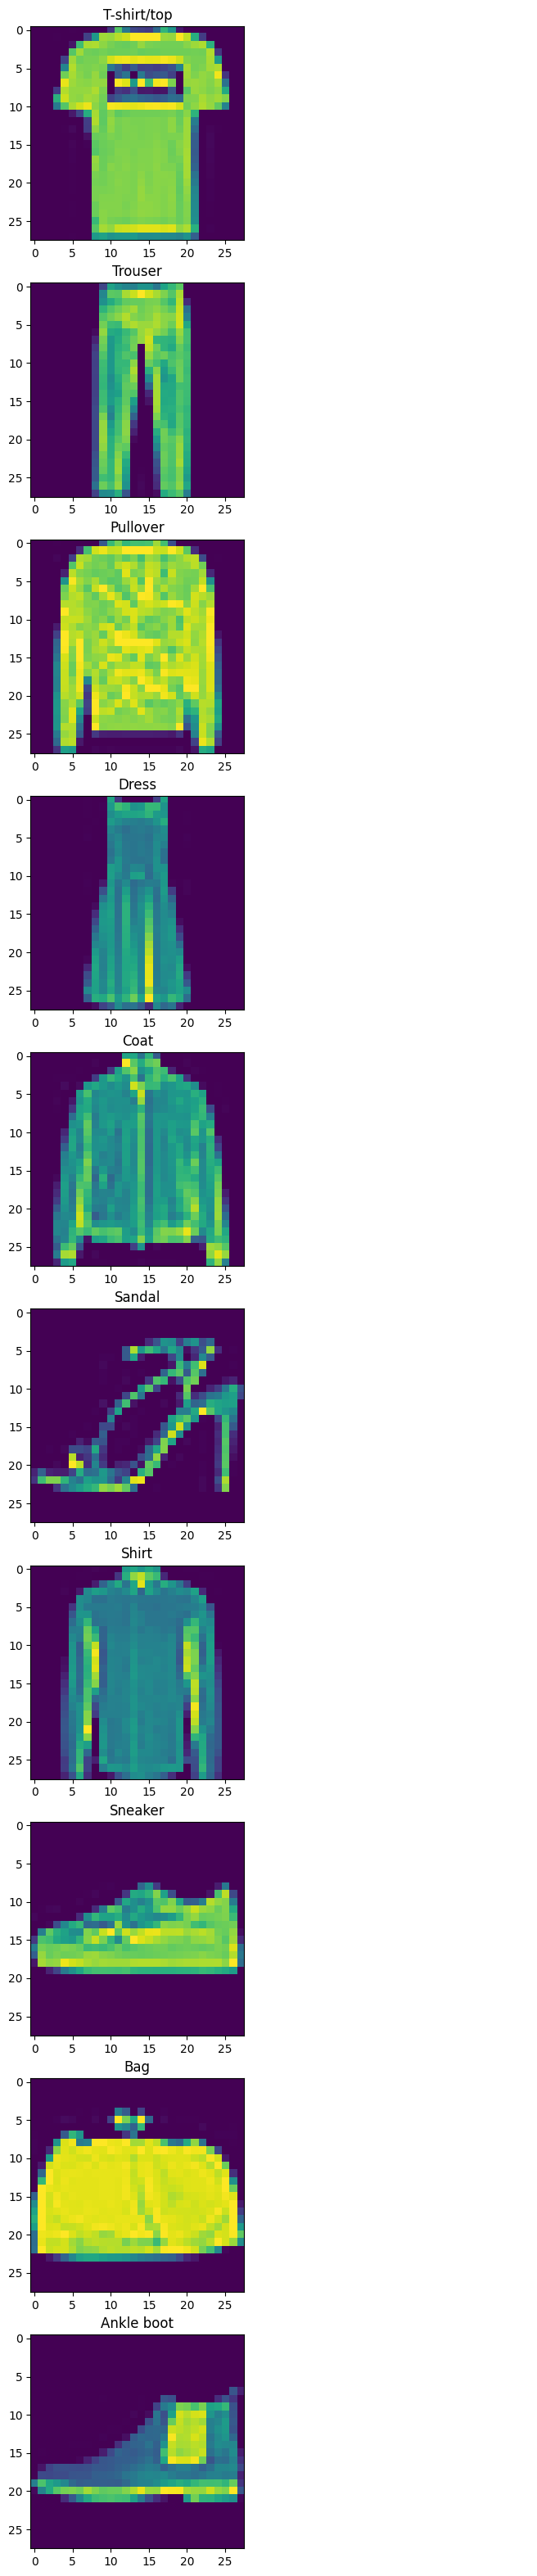

In [5]:
import matplotlib.pyplot as plt
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
import random
ref = dict()
for i in range(10):
    ref[i] = class_names[i]

fig, ax = plt.subplots(10,2,figsize=(8,40))

c=0

for i in range(len(data_train)):
    if(y[i]==c):
        ind1 = c
        ind2 = 0
        ax[ind1,ind2].imshow(np.reshape(data_train[i],(28,28)))
        ax[c][1].axis('off');
        ax[ind1,ind2].set_title(ref[y[i]])
        c+=1
    if c==10:
        break

## B. Network implementation

In [176]:
class ReLU():
    def forward(self, x):
        self.old_x = np.copy(x)
        return np.clip(x,0,None)

    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)

class Sigmoid():
    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad

class Softmax():
    def forward(self,x):
            self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
            return self.old_y

    def backward(self,grad):
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

class CrossEntropy():
    def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)


class Linear():
    def __init__(self,n_in,n_out,momentum=False):
        self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
        self.biases = np.zeros(n_out)

        self.momentum = momentum
        if momentum:
            self.grad_w =self.previous = np.zeros((n_in,n_out))

    def forward(self, x):
        self.old_x = x
        return np.dot(x,self.weights) + self.biases

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)

        if self.momentum:
            self.previous = self.grad_w

        self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
        return np.dot(grad,self.weights.transpose())




## C. Train

In [136]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        self.output = self.forward(x)
        return self.cost.forward(self.output,y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

    def calculate_accuracy(self, real):
        predictedNumber = np.argmax(self.output,axis=1)
        realNumber = np.argmax(real,axis=1)
        return np.mean(predictedNumber == realNumber)


def train(model,lr,nb_epoch,data,label,batch_size=1000):
    loss_train = []
    loss_test = []

    accuracy_train = []
    accuracy_test = []
    for epoch in range(nb_epoch):
        lr = lr * 0.99
        if lr < 1e-3:
            lr = 1e-3

        num_inputs = 0
        running_loss = 0
        accuracy = 0

        number_of_batches = int(data.shape[0]/batch_size)
        for i in range(number_of_batches):
            input = data[i*batch_size:(i+1)*batch_size]
            output = label[i*batch_size:(i+1)*batch_size]
            num_inputs += input.shape[0]
            running_loss += model.loss(input,output).sum()
            model.backward()

            accuracy += model.calculate_accuracy(output)

            for layer in model.layers:
                if type(layer) == Linear:
                    layer.weights -= lr * layer.grad_w
                    layer.biases -= lr * layer.grad_b
        print(f'Epoch {epoch+1}/{nb_epoch}: loss train = {running_loss}')
        print(f'Train accuracy: {accuracy/number_of_batches}')

        loss_test_current = model.loss(data_test,target_test).sum()
        print(f'Epoch {epoch+1}/{nb_epoch}: loss test = {loss_test_current}')
        accuracy_current_test= model.calculate_accuracy(target_test)
        print(f'Test accuracy: {accuracy_current_test}')

        loss_train.append(running_loss)
        loss_test.append(loss_test_current)
        
        accuracy_train.append(accuracy/number_of_batches)
        accuracy_test.append(accuracy_current_test)
    return loss_train,loss_test,accuracy_train,accuracy_test

## d. Results

In [146]:
net = Model([Linear(784,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10), Softmax()], CrossEntropy())

In [147]:
 epoch_count = 30
 loss_train,loss_test,accuracy_train,accuracy_test = train(net,1e-1,epoch_count,data_train,target_train)

Epoch 1/30: loss train = 34273.999245328014
Train accuracy: 0.7943333333333332
Epoch 1/30: loss test = 5882.024706903974
Test accuracy: 0.7845
Epoch 2/30: loss train = 33891.26773555227
Train accuracy: 0.7967333333333333
Epoch 2/30: loss test = 5823.962497812203
Test accuracy: 0.7865
Epoch 3/30: loss train = 33530.60173532922
Train accuracy: 0.7998333333333332
Epoch 3/30: loss test = 5769.388843975354
Test accuracy: 0.7884
Epoch 4/30: loss train = 33190.318871548116
Train accuracy: 0.8021333333333331
Epoch 4/30: loss test = 5717.999626335039
Test accuracy: 0.7909
Epoch 5/30: loss train = 32868.717160099586
Train accuracy: 0.8039666666666668
Epoch 5/30: loss test = 5669.53330350921
Test accuracy: 0.793
Epoch 6/30: loss train = 32564.331491516987
Train accuracy: 0.8061499999999999
Epoch 6/30: loss test = 5623.76092580437
Test accuracy: 0.7947
Epoch 7/30: loss train = 32275.88105378048
Train accuracy: 0.8082166666666668
Epoch 7/30: loss test = 5580.479400607843
Test accuracy: 0.7966
Epoch

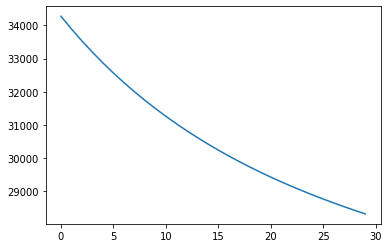

In [148]:
plt.plot(np.arange(epoch_count), loss_train)

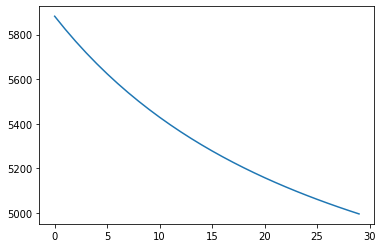

In [149]:
plt.plot(np.arange(epoch_count), loss_test)

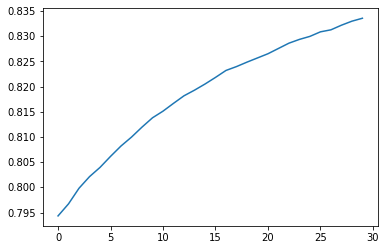

In [150]:
plt.plot(np.arange(epoch_count), accuracy_train)

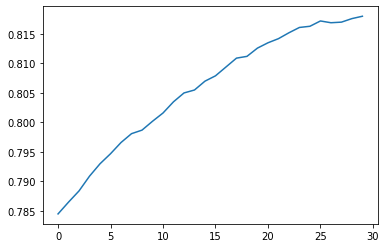

In [151]:
plt.plot(np.arange(epoch_count), accuracy_test)

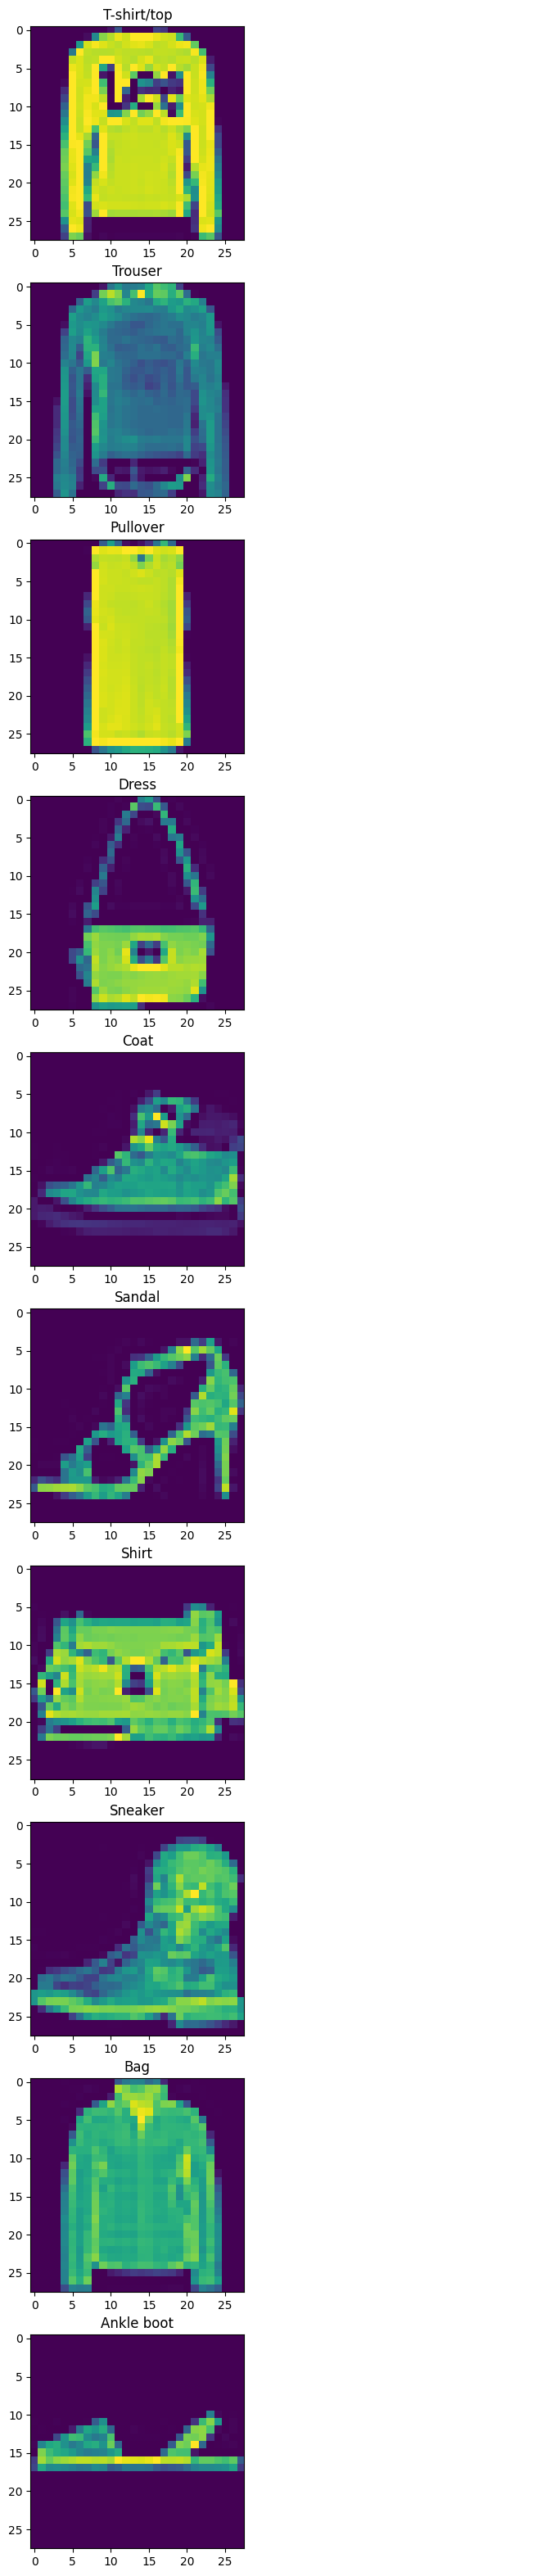

In [7]:
ref = dict()
for i in range(10):
    ref[i] = class_names[i]

fig, ax = plt.subplots(10,2,figsize=(8,40))

c=0
for i in range(len(data_test)):
    if(y[i]==c):
        ind1 = c
        ind2 = 0
        ax[ind1,ind2].imshow(np.reshape(data_test[i],(28,28)))
        ax[c][1].axis('off');
        ax[ind1,ind2].set_title(ref[y[i]])
        c+=1
    if c==10:
        break